## Setup Environment

In [1]:
# start meshcat server
from meshcat.servers.zmqserver import start_zmq_server_as_subprocess
proc, zmq_url, web_url = start_zmq_server_as_subprocess(server_args=['--ngrok_http_tunnel'])

import numpy as np
from IPython.display import display, SVG, HTML
import pydot

import pydrake.all

from pydrake.all import (
    DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, 
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser, MathematicalProgram, eq, PiecewisePolynomial, SnoptSolver, Solve
)

from pydrake.systems.primitives import ConstantVectorSource
from pydrake.autodiffutils import AutoDiffXd
from pydrake.multibody.tree import MultibodyForces_
from pydrake.multibody.plant import MultibodyPlant_
from pydrake.symbolic import Expression

# Luxo Dynamics

Loaded from an `.urdf` file. 

In [2]:
builder = DiagramBuilder()
luxo, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
Parser(luxo).AddModelFromFile("double_pendulum.urdf")
luxo.Finalize()
luxo.set_name('luxo')

# Setup visualization
visualizer = pydrake.systems.meshcat_visualizer.ConnectMeshcatVisualizer(
    builder, 
    scene_graph=scene_graph, 
    zmq_url=zmq_url)
visualizer.vis.delete()
visualizer.set_planar_viewpoint(xmin=-4, xmax=4, ymin=-4, ymax=4)

# Setup torque input
u = np.array([-3,0])
torque_system = builder.AddSystem(ConstantVectorSource(u))
builder.Connect(torque_system.get_output_port(0), luxo.get_input_port(3))

diagram = builder.Build()

# For reference, let's draw the diagram we've assembled:
#display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

# Set up a simulator to run this diagram
simulator = Simulator(diagram)
context = simulator.get_mutable_context()

# Set the initial conditions
context.SetContinuousState([0, 0, 0, 0]) # theta1, theta2, theta1dot, theta2dot
context.SetTime(0.0)

simulator.set_target_realtime_rate(1.0)

while True:
    simulator.AdvanceTo(simulator.get_context().get_time() + 1.0)


Connecting to meshcat-server at zmq_url=tcp://127.0.0.1:6000...
You can open the visualizer by visiting the following URL:
http://579b-54-226-123-23.ngrok.io/static/
Connected to meshcat-server.


KeyboardInterrupt: 

# Trajectory Optimization

In [3]:
def ManipulatorDynamics(plant, q, v=None):
    context = plant.CreateDefaultContext()
    plant.SetPositions(context, q)
    if v is not None:
        plant.SetVelocities(context, v)
    M = plant.CalcMassMatrixViaInverseDynamics(context)
    Cv = plant.CalcBiasTerm(context)
    tauG = plant.CalcGravityGeneralizedForces(context)
    B = plant.MakeActuationMatrix()
    forces = MultibodyForces_(plant)
    plant.CalcForceElementsContribution(context, forces)

    # TODO(russt): add in contact forces to tauExt.
    tauExt = forces.generalized_forces()

    return (M, Cv, tauG, B, tauExt)


def luxo_dynamics(vars):
    nq = luxo_autodiff.num_positions()
    split_at = [nq, 2 * nq, 3 * nq]
    q, qd, qdd, u = np.split(vars, split_at)
    
    # set compass gait state
    context = luxo_autodiff.CreateDefaultContext()
    luxo_autodiff.SetPositions(context, q)
    luxo_autodiff.SetVelocities(context, qd)
    luxo_autodiff.get_actuation_input_port().FixValue(context, u)
    
    # matrices for the manipulator equations
    M, Cv, tauG, B, tauExt = ManipulatorDynamics(luxo_autodiff,q,qd)

    # return violation of the manipulator equations
    return M.dot(qdd) + Cv - tauG -B@u - tauExt

In [5]:
luxo_autodiff = luxo.ToAutoDiffXd() 

# create optimization problem, general formulation
T = 50 # time steps

# minimum and maximum time interval, in seconds
h_min = .005
h_max = .05

# goal, start positions
goal = [0, 0]
start = [0.3, -.7]

torque_limit = 1

# Initialize program
prog = MathematicalProgram()

# Declare decision variables
h = prog.NewContinuousVariables(T, name='h') # distances between break points

nq = luxo_autodiff.num_positions()
q =   prog.NewContinuousVariables(rows=T+1, cols=nq, name='q') # generalized position
qd =  prog.NewContinuousVariables(rows=T+1, cols=nq, name='qd') # generalized velocity
qdd = prog.NewContinuousVariables(rows=T, cols=nq, name='qdd') # generalized acceleration
u =   prog.NewContinuousVariables(rows=T, cols=nq, name='u') #actuation

# Add Constraints
prog.AddLinearConstraint(q[0][0] == start[0]) # Begin in start position.
prog.AddLinearConstraint(q[0][1] == start[1])

prog.AddLinearConstraint(q[-1][1] == goal[1]) # End in goal postiion.
prog.AddLinearConstraint(q[-1][0] == goal[0])
prog.AddLinearConstraint(qd[-1][1] == 0) # End at rest
prog.AddLinearConstraint(qd[-1][0] == 0)

prog.AddBoundingBoxConstraint([h_min] * T, [h_max] * T, h) # lower and upper bound on each timestep

for t in range(T):
    # Enforce derivatives with implicit euler
    prog.AddConstraint(eq(q[t+1], q[t] + h[t] * qd[t+1]))
    prog.AddConstraint(eq(qd[t+1], qd[t] + h[t] * qdd[t]))

    # Enforce luxo's dynamics
    vars = np.concatenate((q[t], qd[t], qdd[t], u[t]))
    prog.AddConstraint(luxo_dynamics, lb=[0]*nq, ub=[0]*nq, vars=vars)
    prog.AddBoundingBoxConstraint(-torque_limit, torque_limit, u[t][0])
    prog.AddBoundingBoxConstraint(-torque_limit, torque_limit, u[t][1])


# Formulate initial 
# Vector of the initial guess
initial_guess = np.empty(prog.num_vars())

# Initial guess for the time step
h_guess = h_max
prog.SetDecisionVariableValueInVector(h, [h_guess] * T, initial_guess)

# Linear interpolation of the configuration
q0_guess = np.array([0, .15])
q_guess_poly = PiecewisePolynomial.FirstOrderHold(
    [0, T * h_guess],
    np.column_stack((q0_guess, - q0_guess))
)
qd_guess_poly = q_guess_poly.derivative()
qdd_guess_poly = q_guess_poly.derivative()

# Set initial guess for configuration, velocity, and acceleration
q_guess = np.hstack([q_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qd_guess = np.hstack([qd_guess_poly.value(t * h_guess) for t in range(T + 1)]).T
qdd_guess = np.hstack([qdd_guess_poly.value(t * h_guess) for t in range(T)]).T
prog.SetDecisionVariableValueInVector(q, q_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qd, qd_guess, initial_guess)
prog.SetDecisionVariableValueInVector(qdd, qdd_guess, initial_guess)


# Solve optimization problem
solver = SnoptSolver()
result = solver.Solve(prog)
print(f'Solution found? {result.is_success()}.')

# get optimal solution
h_opt = result.GetSolution(h)
q_opt = result.GetSolution(q)
qd_opt = result.GetSolution(qd)
qdd_opt = result.GetSolution(qdd)
us_opt = result.GetSolution(u)
x_opt = np.hstack((q_opt, qd_opt)) # stack states

Solution found? True.


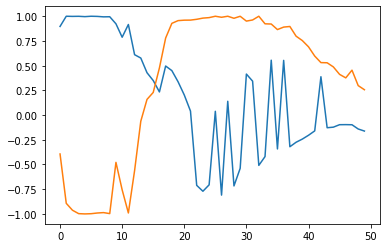

In [6]:
import matplotlib.pyplot as plt
plt.plot(us_opt)
plt.show()

In [7]:
# interpolate state values for animation
time_breaks_opt = np.array([sum(h_opt[:t]) for t in range(T+1)])
x_opt_poly = PiecewisePolynomial.FirstOrderHold(time_breaks_opt, x_opt.T)

# parse urdf with scene graph
from pydrake.all import MultibodyPlant, TrajectorySource, MultibodyPositionToGeometryPose, PlanarSceneGraphVisualizer
ballbot = MultibodyPlant(time_step=0)
scene_graph = SceneGraph()
ballbot.RegisterAsSourceForSceneGraph(scene_graph)
Parser(ballbot).AddModelFromFile("double_pendulum.urdf")
ballbot.Finalize()

# build block diagram and drive system state with
# the trajectory from the optimization problem
builder = DiagramBuilder()
source = builder.AddSystem(TrajectorySource(x_opt_poly))
builder.AddSystem(scene_graph)
pos_to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(ballbot, input_multibody_state=True))
builder.Connect(source.get_output_port(0), pos_to_pose.get_input_port())
builder.Connect(pos_to_pose.get_output_port(), scene_graph.get_source_pose_port(ballbot.get_source_id()))

# add visualizer
xlim = [-3, 3]
ylim = [-3, 3]
visualizer = builder.AddSystem(PlanarSceneGraphVisualizer(scene_graph, xlim=xlim, ylim=ylim, show=False))
builder.Connect(scene_graph.get_query_output_port(), visualizer.get_input_port(0))
simulator = Simulator(builder.Build())

# generate and display animation
visualizer.start_recording()
simulator.AdvanceTo(x_opt_poly.end_time())
ani = visualizer.get_recording_as_animation()
HTML(ani.to_jshtml())

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5fd8e1d3-71c2-47d4-871c-7eed4e2b387c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>